In [1]:
# For data processing
from tensorflow.keras.layers import Dense, LSTM, Dropout, PReLU, RepeatVector, TimeDistributed, Attention
import gc
import os
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from keras.layers.merge import concatenate
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import SimpleRNN as Recurrent
from tensorflow.keras import regularizers, constraints, initializers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras import backend
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from scipy.stats import hmean
import json
from os import path
import numpy as np
import math
from math import sqrt

# For data processing and manipulation
import pandas as pd
import csv

# For date calculations
import datetime
import time

# For ploting data
import IPython
import IPython.display

import itertools
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# For checking path


#tensorflow libs

#from keras.layers.recurrent import Recurrent, _time_distributed_dense
#from tensorflow.compat.v1.keras.layers import RNN


tf.get_logger().setLevel('ERROR')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
ROOTPATH = r"C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather_take_all_the_city_one(lstm)"
MODEL_PATH = ROOTPATH+"/models"
HISTORY_PATH = ROOTPATH+"/histories"
one_hot_data=pd.read_csv(r"C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather_take_all_the_city_one(lstm)\data.csv")
one_hot_data.drop(['Unnamed: 0', 'wind_speed','wind_direction', 'date'], inplace=True, axis=1)
one_hot_data.columns

Index(['rain_fall', 'sunshine', 'humidity', 'temperature', 'Wx', 'Wy',
       'station_name_ambaganctg', 'station_name_barisal', 'station_name_bhola',
       'station_name_bogra', 'station_name_chandpur',
       'station_name_chittagong', 'station_name_chuadanga',
       'station_name_comilla', 'station_name_coxsbazar', 'station_name_dhaka',
       'station_name_dinajpur', 'station_name_faridpur', 'station_name_feni',
       'station_name_hatiya', 'station_name_ishurdi', 'station_name_jessore',
       'station_name_khepupara', 'station_name_khulna',
       'station_name_kutubdia', 'station_name_madaripur',
       'station_name_mcourt', 'station_name_mongla', 'station_name_mymensingh',
       'station_name_patuakhali', 'station_name_rajshahi',
       'station_name_rangamati', 'station_name_rangpur',
       'station_name_sandwip', 'station_name_satkhira',
       'station_name_sitakunda', 'station_name_srimangal',
       'station_name_sydpur', 'station_name_sylhet', 'station_name_tangail'

In [3]:
def split_data(df):
    '''
    split the dataset ( train , val , test = (70 , 15 , 15)% )
    input:
        df : Dataset to split
    output:
        train_df : train dataset
        val_df : validation dataset
        test_df : test dataset
        num_features : Number of features in dataset
        column_indices : column_indices in dataset
    '''
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.85)]
    test_df = df[int(n*0.85):]

    num_features = df.shape[1]
    return train_df, val_df, test_df, num_features, column_indices


In [4]:
def create_data(train, test, val, columns):
    '''
    Create dataset from main train , test , val with given columns
    '''
    if(columns == None):
        columns = train.columns
    new_train = train[columns]
    new_test = test[columns]
    new_val = val[columns]
    return new_train, new_test, new_val


In [5]:
def normalize_MinMax(train , val , test):
    train_max = train.max()
    train_min = train.min()
    
    train = (train - train_min)/(train_max - train_min)
    val = (val - train_min)/ (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)
    return train , val , test , train_max , train_min

In [6]:
def normalize_std(train , val , test):
    train_mean = train.mean()
    train_std = train.std()
    for x in y_col:
        train[x] = (train[x] - train_mean[x]) / train_std[x]
        val[x] = (val[x] - train_mean[x]) / train_std[x]
        test[x] = (test[x] - train_mean[x]) / train_std[x]
    return train , val ,test , train_mean , train_std

In [7]:
class WindowGenerator():
    '''
    WindowGenerator Class
    1. Split windows of features into a (features, labels) pairs.
    2. Plot the content of the resulting windows.
    3. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets S.
    '''
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None , shuffle=False , batch_size = 64):
        '''
        The __init__ method includes all the necessary logic for the input and label indices.
        Input: 
            input_width : input width / window size 
            label_width : output width
            shift : size of window shifting forward
            train_df : train dataset
            val_df : validation dataset
            test_df : test dataset
            label_columns ( Default = None) : Label Columns
            shuffle ( Default = False) : weather to shuffle data 
            batch_size (Default = 64) : Batch Size
        Output: None
        Example :
            w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['count'])
            w2

        '''
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.shuffle = shuffle
        self.batch_size = batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #(start , stop)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        '''
        Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.
        
        Input: 
            features : Stack of array of datas , used for splitting data to inputs and labels
        Output:
            inputs : nd Array splitted as input_width
            labesl : nd Array splitted as label_width
        Example :
        # Stack three slices, the length of the total window:
            example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


            example_inputs, example_labels = w2.split_window(example_window)

            print('All shapes are: (batch, time, features)')
            print(f'Window shape: {example_window.shape}')
            print(f'Inputs shape: {example_inputs.shape}')
            print(f'labels shape: {example_labels.shape}')
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        #taking only the labels that are presentin the label_columns
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='temperature', max_subplots=3):
        '''
            plot method that allows a simple visualization of the split window,
            Input:
                model (Default=None) : tensorflow model to evaluate 
                plot_col ( Default = 'count') : Name of column to evaluate
                max_subplots ( Default = 3) : Maximum Number of subplotting
            Output:
                None
            Example:
                w2.plot()
                w2.plot(plot_col=0) # label wont be shown as w2 config has only column , count 

        '''
        inputs, labels = self.example
        plt.figure(figsize=(15, 12))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        '''
        make_dataset method will take a time series DataFrame and convert it to a
            tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function.
        Input:
            data :  Input data to transform into (input_window , label_window)
        Output:
            ds : transformed dataset
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=self.shuffle,
            batch_size=self.batch_size,)
        ds = ds.map(self.split_window)
        return ds
    
    def create_dataset2(self , map_df , reshape=True):
      x = []
      y = []
      for res in iter(map_df):
        inputs, labels = res
        if(len(inputs)==64):
          x.append(inputs)
          y.append(labels)
      
      x = np.array(x)
      y = np.array(y)
      if(reshape):
        x = x.reshape(-1, x.shape[-2] , x.shape[-1])
        y = y.reshape(-1 , y.shape[-2] , y.shape[-1])
      return x , y
    
    '''
    properties for accessing  training, validation and test data as tf.data.Datasets using the above make_dataset method.
    Also a standard example batch for easy access and plotting
    '''

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [8]:
y_col=['rain_fall', 'sunshine', 'humidity', 'temperature','Wx', 'Wy']


In [9]:
def save_history(history , path):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    # or save to csv: 
    hist_csv_file = path
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_json(f)

def get_history(path):
    with open(path) as json_file:
        data = json.load(json_file)
        return data

def save_model_weights(model , path):
  model.save_weights(path)


In [10]:
def sMAPE(y, y_pred):
    epsilon = 0.1
    summ = backend.maximum(backend.abs(
        y) + backend.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = backend.abs(y_pred - y) / summ * 2.0
    return smape


In [11]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

In [12]:
metrics_name = ['mae' , 'msle' , 'mse' , 'smape' , 'r^2']

In [13]:
def compileModel(model):
    model.compile(loss=tf.losses.MeanAbsoluteError(), optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanSquaredLogarithmicError(), tf.metrics.MeanSquaredError(), sMAPE, R_squared])
    return model


In [14]:
MAX_EPOCHS = 20
from keras.callbacks import ModelCheckpoint
def compile_and_fit(model, modelPath , historyPath , window=None, name=None , patience=10):
    '''
    Compile and fit a model
    '''
    modelPathPar = MODEL_PATH+'/'+modelPath+'/'
    historyPathPar = HISTORY_PATH+'/'+historyPath+'/'
    if (name!=None):
        # model_path = ROOTPATH+'/model_all_mae_swish/'+name
        # history_path = ROOTPATH+'/history_all_mae_swish/'+name+".json"
        model_path = modelPathPar+name
        history_path = historyPathPar+name+".json"
        
        if not path.exists(modelPathPar):
            os.makedirs(modelPathPar)
        if not path.exists(historyPathPar):
            os.makedirs(historyPathPar)

    if (name!=None and path.exists(model_path)):
      print("Loaded Pre Trained Model")
      modelOld = tf.keras.models.load_model(model_path, custom_objects={
                                            'sMAPE': sMAPE, "R_squared": R_squared})
      model.set_weights(modelOld.get_weights())
      history = get_history(history_path)
      return model , history
      
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True,mode='min',save_weights_only=False)
    history = model.fit(window.train, epochs=MAX_EPOCHS,validation_data=window.val,callbacks=[early_stopping])
    if(name!=None):
      model.save(model_path)
      save_history(history , history_path)
    return model , history.history


In [15]:
def generate_window(df_now, ret_test = 0):
    train_df , val_df , test_df , num_features_df , column_indices_df = split_data(df_now)
    train_df , test_df , val_df = create_data(train_df , test_df , val_df , None)
    train_df , val_df , test_df , train_mean , train_std = normalize_std(train_df , val_df , test_df)

    wide_window_all = WindowGenerator(train_df=train_df, test_df=test_df , val_df=val_df, 
        input_width=14, label_width=14, shift=1,
        label_columns=y_col)
    print(train_std , train_mean)
    print(train_df.head())
    if (ret_test == 1):
      return wide_window_all, test_df, train_mean, train_std
    else:  
      return wide_window_all, train_mean, train_std

In [24]:
input_lstm = keras.Input(shape=(14,41), name="input_LSTM")
x_bd = tf.keras.layers.LSTM(32, activation = tf.keras.activations.swish ,return_sequences=True)(input_lstm)
x_bd = (TimeDistributed(keras.layers.Dense(units=16, activation = tf.keras.activations.swish), name="TimeDisDenseLSTM"))(x_bd)
output_lstm = (keras.layers.Dense(units=len(y_col)))(x_bd)
 
lstm_model_all_feature = keras.Model(
    inputs=[input_lstm],
    outputs=[output_lstm],
)
lstm_model_all_feature.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_LSTM (InputLayer)     [(None, 14, 41)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            9472      
                                                                 
 TimeDisDenseLSTM (TimeDistr  (None, 14, 16)           528       
 ibuted)                                                         
                                                                 
 dense_3 (Dense)             (None, 14, 6)             102       
                                                                 
Total params: 10,102
Trainable params: 10,102
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Load Attn_LSTM MODEL
val_performance_bi_lstm = {}
performance_bi_lstm = {}
histories = {}
attn_lstm_model_all_feature = compileModel(lstm_model_all_feature)

wide_window_all , train_max , train_min = generate_window(one_hot_data)
x="all_the_data"
lstm_model_all_feature, history = compile_and_fit(
    lstm_model_all_feature, "model_lstm_"+x, "history_lstm", name='Bi_LSTM_'+x, window=wide_window_all)
histories["lstm_all"+x] = history  
val_performance_bi_lstm[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.val)
performance_bi_lstm[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.test)

IPython.display.clear_output()


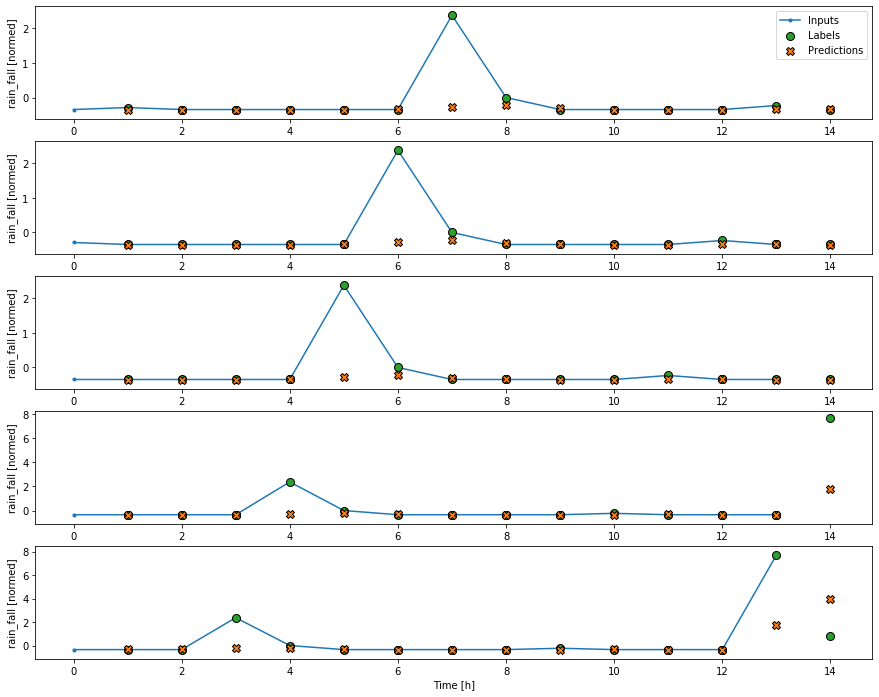

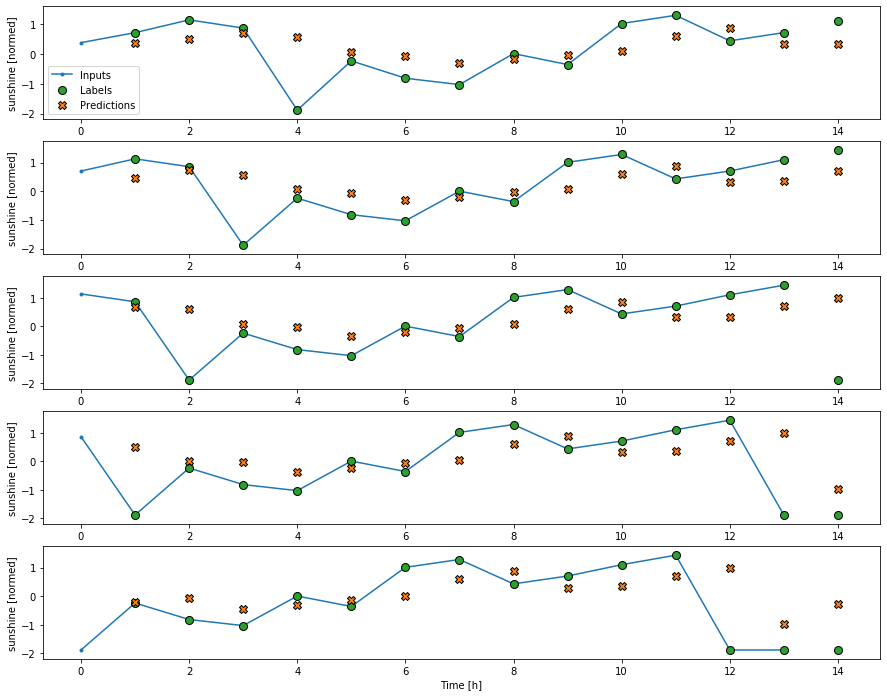

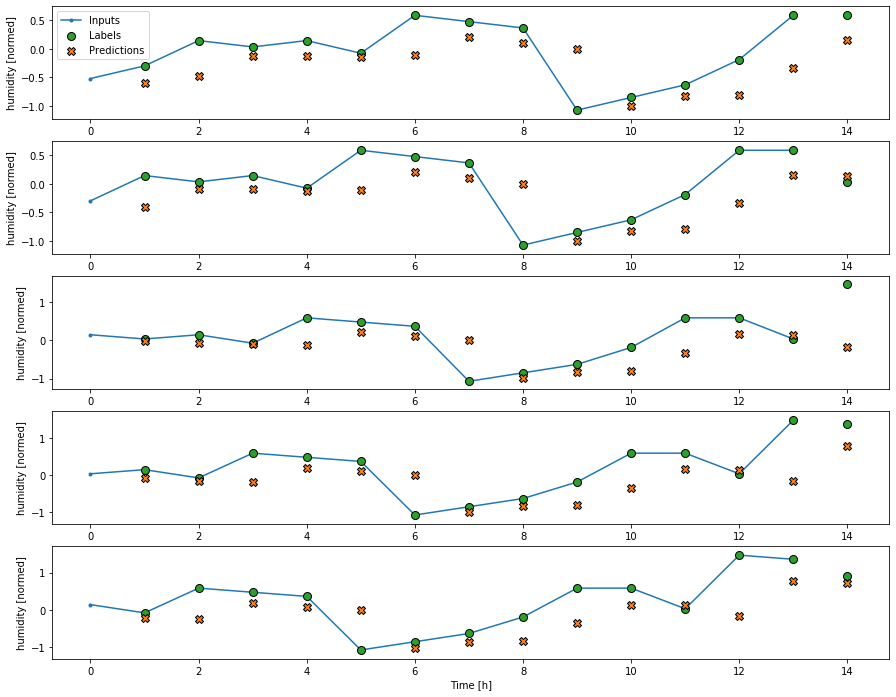

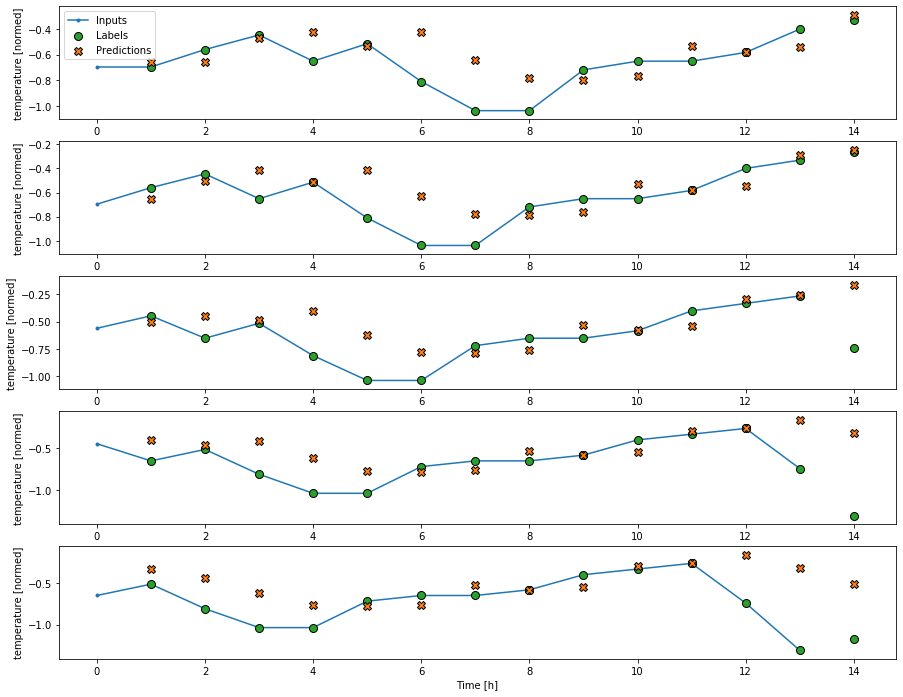

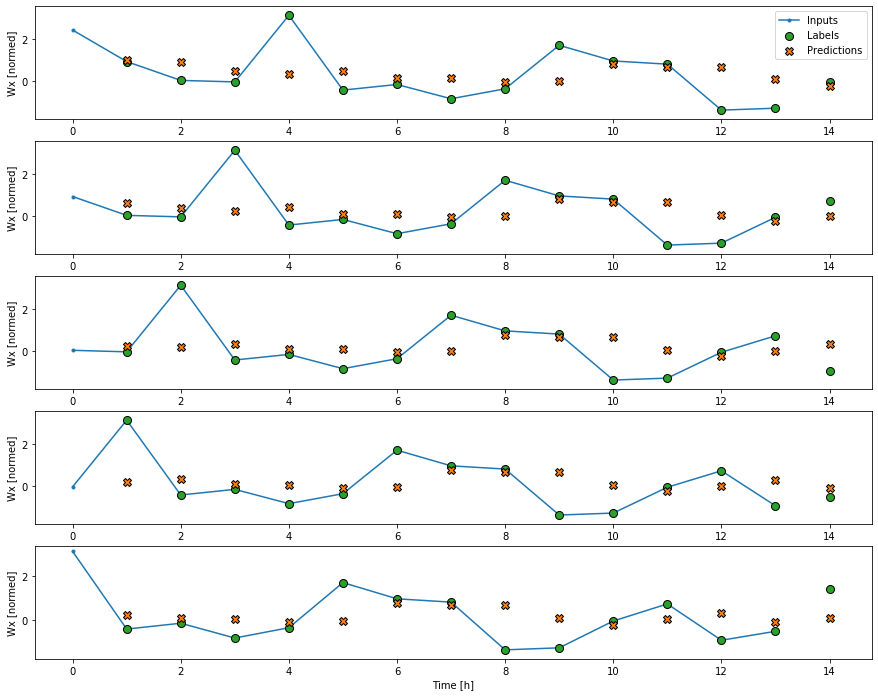

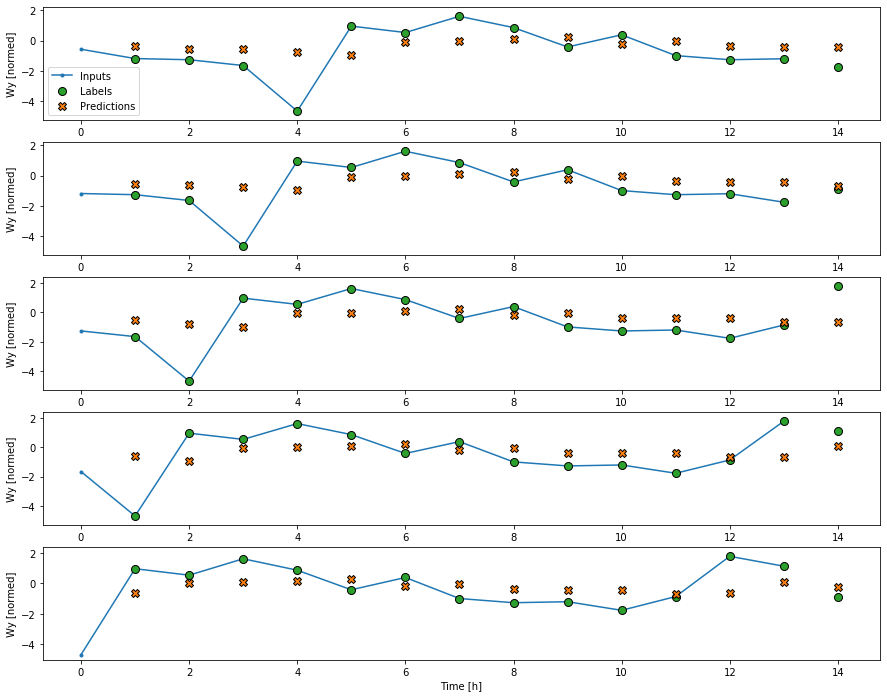

In [29]:
#wide_window_all = generate_window(dataset_city['dhaka'])
for x in y_col:
    wide_window_all.plot(lstm_model_all_feature ,x ,max_subplots=5)

In [30]:
def print_perf_val_perf(perf , val_perf):
    print(f'{"model":50s}: Test   | Val')
    for i in range(len(metrics_name)):
        print("==================",metrics_name[i],"==================")
        for key in val_perf.keys():
            print(f'{str(key):50s}: {perf[key][i]:0.4f} | {val_perf[key][i]:0.4f}')
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
f=open(ROOTPATH+"\\result\\"+dt_string+".txt",'w')
import sys
orig_stdout = sys.stdout
sys.stdout = f
print_perf_val_perf(performance_bi_lstm , val_performance_bi_lstm)
sys.stdout = orig_stdout
f.close()

model                                             : Test   | Val
================== mae ==================
all_the_data                                      : 0.4279 | 0.4971
================== msle ==================
all_the_data                                      : 0.0639 | 0.0740
================== mse ==================
all_the_data                                      : 0.5150 | 0.6873
================== smape ==================
all_the_data                                      : 0.6433 | 0.6467
================== r^2 ==================
all_the_data                                      : 0.4837 | 0.4732


In [ ]:
def draw(xAxis,yAxis,xname,yname,city):
    from matplotlib import pyplot as plt
    plt.grid(True)
    ## LINE GRAPH ##
    plt.title(city)
    plt.plot(xAxis,yAxis, color='maroon', marker='o')
    plt.xlabel(xname)
    plt.ylabel(yname)

    ## BAR GRAPH ##
    #fig = plt.figure()
    #plt.bar(xAxis,yAxis, color='maroon')
    #plt.xlabel(xname)
    #plt.ylabel(yname)
    #C:\Users\Inception\Desktop\research\bd_weather_all\bd_weather_updated\BD_Weather\loss pic
    plt.savefig(ROOTPATH+"\loss_pic(all the city one model)\\"+ yname+".png")
    plt.show()
    
import json
path=r"C:\Users\Inception\Desktop\research\bd_weather_all\BD_Weather_take_all_the_city_one\histories\history_lstm\Bi_LSTM_all_the_data.json"
dictionary = json.load(open(path, 'r'))
print("*"*30)
for k,l in dictionary.items():
    xAxis = [key for key, value in dictionary[k].items()]
    yAxis = [value for key, value in dictionary[k].items()]
    draw(xAxis,yAxis,"epochs",k,"All city(One model)")